# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$





```
# Выбран кодовый формат
```

where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

In [1]:
import nltk
from nltk.corpus import brown
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

nltk.download('brown')
words = brown.words()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [2]:
# Normalize words (lowercase)
words = [w.lower() for w in words]

# Count frequencies
freqs = Counter(words)

# Sort frequencies in descending order
sorted_freqs = sorted(freqs.values(), reverse=True)

# Total number of tokens, total number of unique words
total_tokens = sum(sorted_freqs)
N = len(sorted_freqs)

print(f"Total tokens: {total_tokens}")
print(f"Unique words (N): {N}")


Total tokens: 1161192
Unique words (N): 49815


In [3]:
cumulative_freqs = np.cumsum(sorted_freqs)
coverage = cumulative_freqs / total_tokens
vocab_sizes = np.arange(1, N + 1)
print(coverage)

[0.06025791 0.11049422 0.1529902  ... 0.99999828 0.99999914 1.        ]


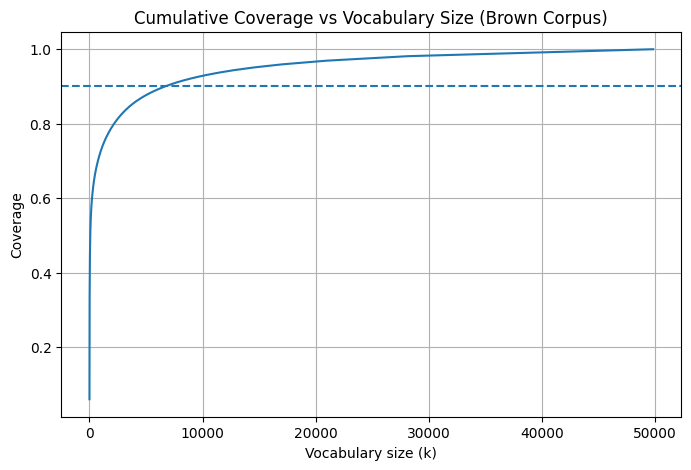

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(vocab_sizes, coverage)
plt.axhline(0.9, linestyle='--')
plt.xlabel("Vocabulary size (k)")
plt.ylabel("Coverage")
plt.title("Cumulative Coverage vs Vocabulary Size (Brown Corpus)")
plt.grid(True)
plt.show()


In [5]:
# Find minimal k such that coverage >= 0.9
k_90 = np.argmax(coverage >= 0.9) + 1

print(f"Minimal vocabulary size covering at least 90%: {k_90}")


Minimal vocabulary size covering at least 90%: 6671


Why the coverage slows down the increase as the vocabulary size increases?

Because word frequency distribution is highly skewed. A small number of words occur very frequently. A very large number of words occur very rarely.

After including common words, adding new vocabulary items mostly adds rare words, which contribute very little to total token mas

**Which empirical law explains the slowing down increase of the coverage?**

Zipf’s Law. It states that the frequency of a word is inversely proportional to its rank.

This produces: rapid initial coverage growth, long tail of rare words, diminishing returns when expanding vocabulary

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [6]:
import re
from collections import defaultdict, Counter
from typing import List, Tuple


class BPETokenizer:

    def __init__(self):
        self.vocab = {}       # word, frequency
        self.merges = []      # list of learned merge tuples
        self.bpe_ranks = {}   # map merge to rank for fast lookup

    def get_stats(self) -> Counter:
        pairs = Counter()
        for word, freq in self.vocab.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pairs[(symbols[i], symbols[i+1])] += freq
        return pairs

    def merge_vocab(self, pair: Tuple[str, str]):
        pattern = r'(?<!\S)' + re.escape(' '.join(pair)) + r'(?!\S)'
        new_vocab = {}

        # Replace the pair in all vocab entries
        for word, freq in self.vocab.items():
            new_word = re.sub(pattern, ''.join(pair), word)
            new_vocab[new_word] = freq

        self.vocab = new_vocab

    def train(self, corpus: List[str], num_merges: int = 1000):
        # Build initial vocabulary: split words into characters, end-of-word marker
        tokens = []
        for sentence in corpus:
            for word in sentence.strip().split():
                tokens.append(word)

        # Count frequency of each token
        self.vocab = defaultdict(int)
        for token in tokens:
            chars = " ".join(list(token)) + " </w>"
            self.vocab[chars] += 1

        # Learn merges
        for i in range(num_merges):
            pairs = self.get_stats()
            if not pairs:
                break

            # Select most frequent pair
            best_pair = max(pairs, key=pairs.get)
            if pairs[best_pair] < 2:
                break

            # Store merge info, merge in vocab
            self.merges.append(best_pair)
            self.bpe_ranks[best_pair] = i
            self.merge_vocab(best_pair)

    def tokenize_word(self, word: str) -> List[str]:
        # initialize with characters, end-of-word
        word = list(word) + ["</w>"]
        pairs = [(word[i], word[i+1]) for i in range(len(word)-1)]

        while True:
            # find candidate pairs that are in the learned merges
            candidates = {pair: self.bpe_ranks[pair] for pair in pairs if pair in self.bpe_ranks}
            if not candidates:
                break

            # choose merge with smallest rank
            best_pair = min(candidates, key=candidates.get)

            new_word = []
            i = 0
            while i < len(word):
                j = -1
                # check if pair matches
                if i < len(word) - 1 and (word[i], word[i+1]) == best_pair:
                    new_word.append(word[i] + word[i+1])
                    j = i + 1
                else:
                    new_word.append(word[i])

                # advance
                i = i+2 if j != -1 else i+1

            word = new_word
            pairs = [(word[i], word[i+1]) for i in range(len(word)-1)]

        # drop end-of-word symbol if desired or keep
        return word

    def tokenize(self, text: str) -> List[str]:
        tokens: List[str] = []
        for word in text.strip().split():
            tokens.extend(self.tokenize_word(word))
        return tokens


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [7]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors
from nltk.corpus import brown
import numpy as np
import nltk


In [8]:
sentences = brown.sents()[:1000]
texts = [" ".join(sent) for sent in sentences]

# Initialize a BPE tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Train the tokenizer
trainer = trainers.BpeTrainer(vocab_size=6671, min_frequency=1, show_progress=True)
tokenizer.train_from_iterator(texts, trainer=trainer)

# Tokenize sentences and calculate metrics
fertilities = []  # tokens per word
sentence_lengths = []  # tokens per sentence

for sent in texts:
    encoding = tokenizer.encode(sent)
    tokens = encoding.tokens
    num_tokens = len(tokens)
    num_words = len(sent.split())

    sentence_lengths.append(num_tokens)
    fertilities.extend([num_tokens / num_words])  # fertility per sentence

# Calculate mean and std
fertility_mean = np.mean(fertilities)
fertility_std = np.std(fertilities)

sentence_length_mean = np.mean(sentence_lengths)
sentence_length_std = np.std(sentence_lengths)

print(f"Fertility mean: {fertility_mean:.4f}, std: {fertility_std:.4f}")
print(f"Sentence length mean: {sentence_length_mean:.4f}, std: {sentence_length_std:.4f}")

Fertility mean: 1.0888, std: 0.1157
Sentence length mean: 23.8930, std: 13.1181


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.